In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import img_as_float
from sklearn.linear_model import LinearRegression
from skimage.metrics import structural_similarity as ssim
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso
import pandas as pd

images with missing part has been generated with percentage of missing 10, 20 and 30

This cell defines a function to fill missing pixels with the global mean and gaussion and uniform of the image

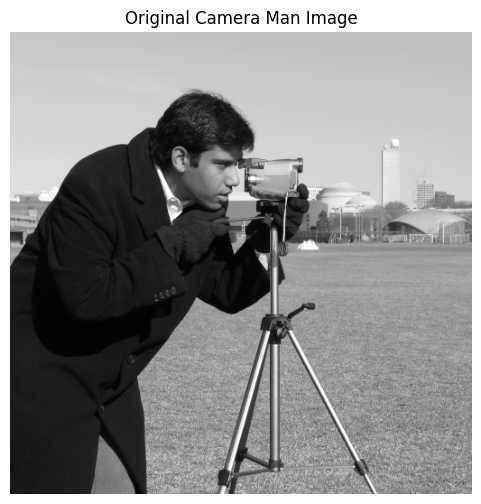

In [50]:


# --- Load the camera_man image ---
image = data.camera()

# --- Display the image ---
plt.figure(figsize=(6,6))
plt.imshow(image, cmap='gray')
plt.title('Original Camera Man Image')
plt.axis('off')
plt.show()

camera man pic

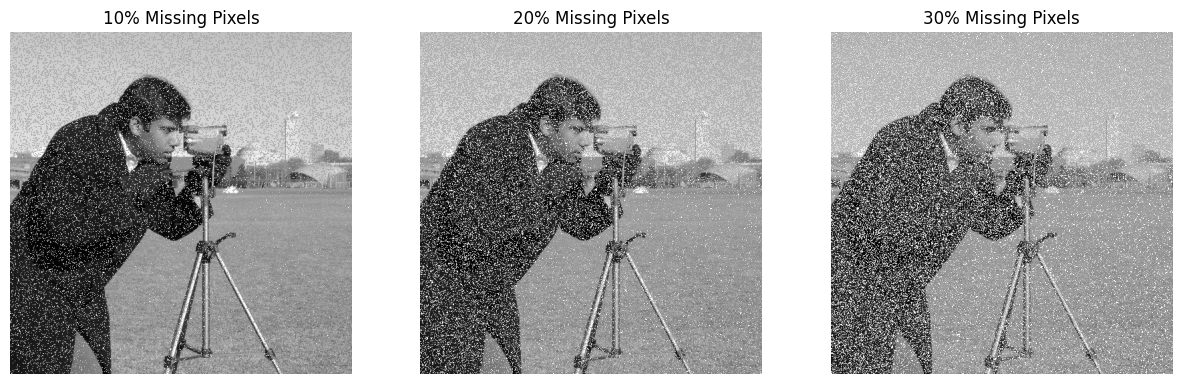

In [51]:
# --- Function to randomly mask pixels ---
def create_missing_pixels(image, missing_ratio):
    """
    image: 2D numpy array
    missing_ratio: fraction of pixels to remove (0.1, 0.2, 0.3)
    """
    masked_image = image.astype(float).copy()
    total_pixels = image.size
    n_missing = int(total_pixels * missing_ratio)
    
    # Generate random indices to mask
    missing_indices = np.unravel_index(
        np.random.choice(total_pixels, n_missing, replace=False),
        image.shape
    )
    
    masked_image[missing_indices] = np.nan
    return masked_image

# --- Create masked images with 10%, 20%, 30% missing ---
image_missing_10 = create_missing_pixels(image, 0.10)
image_missing_20 = create_missing_pixels(image, 0.20)
image_missing_30 = create_missing_pixels(image, 0.30)

# --- Display the images ---
fig, axes = plt.subplots(1,3, figsize=(15,5))
for ax, img, perc in zip(axes, [image_missing_10, image_missing_20, image_missing_30], [10, 20, 30]):
    ax.imshow(img, cmap='gray')
    ax.set_title(f'{perc}% Missing Pixels')
    ax.axis('off')
plt.show()


camera man image with 10%, 20%, 30$ of missing data

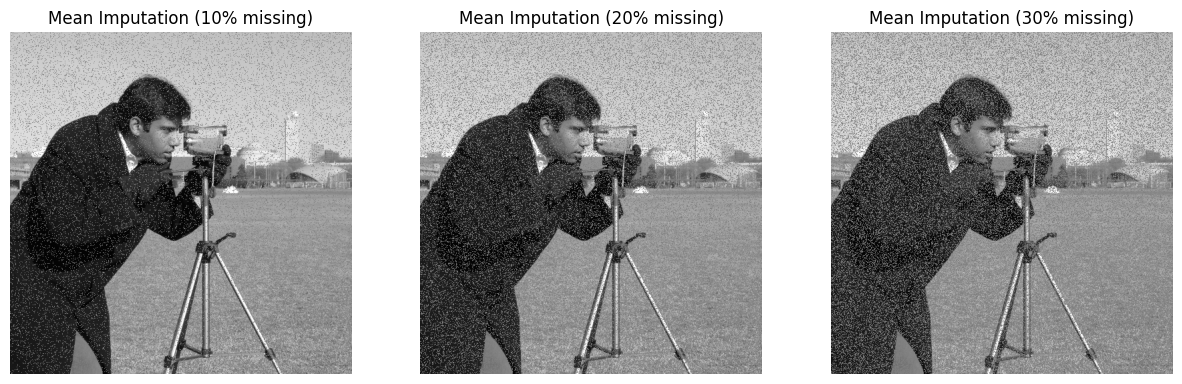

SSIM (Mean Imputation):
10% missing: 0.4382
20% missing: 0.3533
30% missing: 0.3037


In [52]:
# --- Function to fill missing pixels with global mean ---
def impute_mean(masked_image):
    """
    masked_image: 2D numpy array with NaN for missing pixels
    """
    filled_image = masked_image.copy()
    mean_val = np.nanmean(filled_image)
    filled_image[np.isnan(filled_image)] = mean_val
    return filled_image

# --- Apply mean imputation ---
reconstructed_mean_10 = impute_mean(image_missing_10)
reconstructed_mean_20 = impute_mean(image_missing_20)
reconstructed_mean_30 = impute_mean(image_missing_30)

# --- Display reconstructed images ---
fig, axes = plt.subplots(1,3, figsize=(15,5))
for ax, img, perc in zip(axes, [reconstructed_mean_10, reconstructed_mean_20, reconstructed_mean_30], [10, 20, 30]):
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Mean Imputation ({perc}% missing)')
    ax.axis('off')
plt.show()

# --- Compute SSIM compared to original ---
ssim_10 = ssim(image, reconstructed_mean_10, data_range=image.max()-image.min())
ssim_20 = ssim(image, reconstructed_mean_20, data_range=image.max()-image.min())
ssim_30 = ssim(image, reconstructed_mean_30, data_range=image.max()-image.min())

print("SSIM (Mean Imputation):")
print(f"10% missing: {ssim_10:.4f}")
print(f"20% missing: {ssim_20:.4f}")
print(f"30% missing: {ssim_30:.4f}")

This cell defines a function to fill missing pixels with the global mean of the image

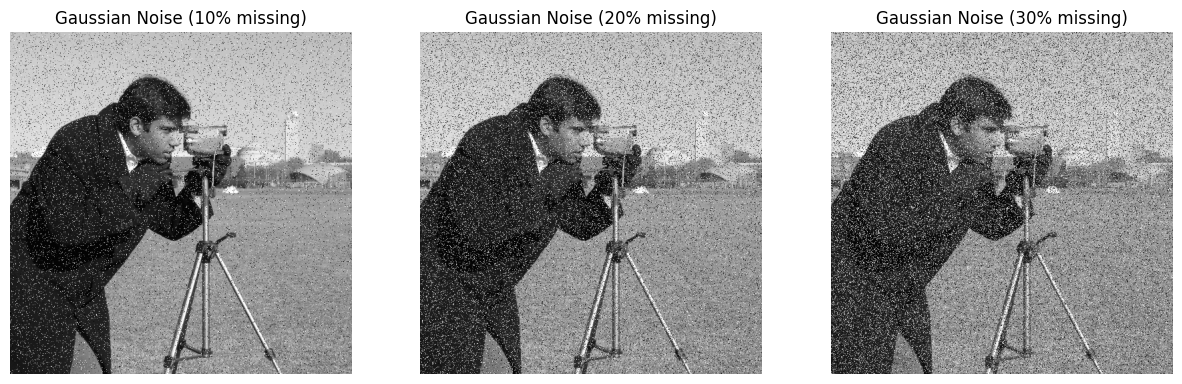

SSIM (Gaussian Noise Imputation):
10% missing: 0.3043
20% missing: 0.1853
30% missing: 0.1323


In [53]:
# --- Function to fill missing pixels with Gaussian noise ---
def impute_gaussian(masked_image):
    """
    masked_image: 2D numpy array with NaN for missing pixels
    Fill missing pixels with Gaussian noise based on mean and std of known pixels
    """
    filled_image = masked_image.copy()
    mean_val = np.nanmean(filled_image)
    std_val = np.nanstd(filled_image)
    
    # Indices of missing pixels
    missing_idx = np.isnan(filled_image)
    
    # Fill with Gaussian random values
    filled_image[missing_idx] = np.random.normal(loc=mean_val, scale=std_val, size=missing_idx.sum())
    
    # Clip to valid pixel range
    filled_image = np.clip(filled_image, 0, 255)
    return filled_image

# --- Apply Gaussian noise imputation ---
reconstructed_gauss_10 = impute_gaussian(image_missing_10)
reconstructed_gauss_20 = impute_gaussian(image_missing_20)
reconstructed_gauss_30 = impute_gaussian(image_missing_30)

# --- Display reconstructed images ---
fig, axes = plt.subplots(1,3, figsize=(15,5))
for ax, img, perc in zip(axes, [reconstructed_gauss_10, reconstructed_gauss_20, reconstructed_gauss_30], [10, 20, 30]):
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Gaussian Noise ({perc}% missing)')
    ax.axis('off')
plt.show()

# --- Compute SSIM ---
ssim_gauss_10 = ssim(image, reconstructed_gauss_10, data_range=image.max()-image.min())
ssim_gauss_20 = ssim(image, reconstructed_gauss_20, data_range=image.max()-image.min())
ssim_gauss_30 = ssim(image, reconstructed_gauss_30, data_range=image.max()-image.min())

print("SSIM (Gaussian Noise Imputation):")
print(f"10% missing: {ssim_gauss_10:.4f}")
print(f"20% missing: {ssim_gauss_20:.4f}")
print(f"30% missing: {ssim_gauss_30:.4f}")


This cell fills missing pixels with Gaussian noise sampled from a normal distribution using the mean and standard deviation of the known pixels

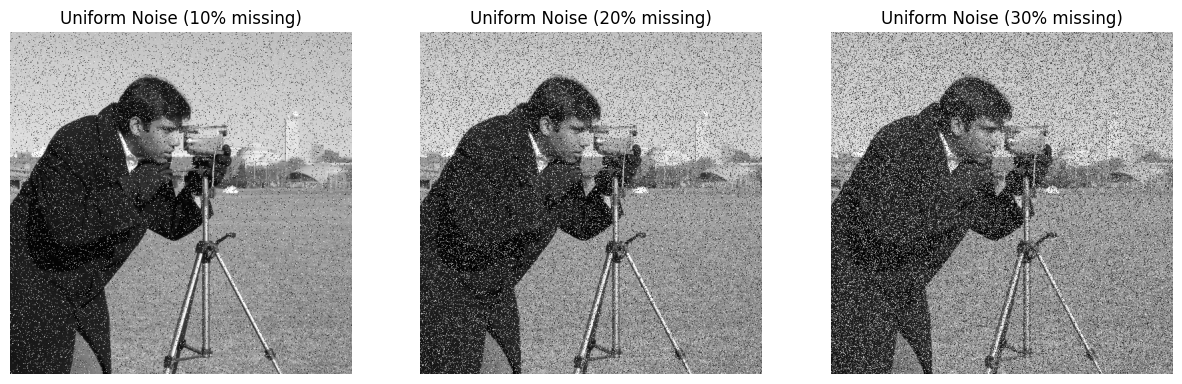

SSIM (Uniform Noise Imputation):
10% missing: 0.2883
20% missing: 0.1719
30% missing: 0.1223


In [54]:
# --- Function to fill missing pixels with Uniform noise ---
def impute_uniform(masked_image):
    """
    masked_image: 2D numpy array with NaN for missing pixels
    Fill missing pixels with Uniform random values in the range of image
    """
    filled_image = masked_image.copy()
    min_val = np.nanmin(filled_image)
    max_val = np.nanmax(filled_image)
    
    # Indices of missing pixels
    missing_idx = np.isnan(filled_image)
    
    # Fill with Uniform random values
    filled_image[missing_idx] = np.random.uniform(low=min_val, high=max_val, size=missing_idx.sum())
    
    # Clip to valid pixel range
    filled_image = np.clip(filled_image, 0, 255)
    return filled_image

# --- Apply Uniform noise imputation ---
reconstructed_uniform_10 = impute_uniform(image_missing_10)
reconstructed_uniform_20 = impute_uniform(image_missing_20)
reconstructed_uniform_30 = impute_uniform(image_missing_30)

# --- Display reconstructed images ---
fig, axes = plt.subplots(1,3, figsize=(15,5))
for ax, img, perc in zip(axes, [reconstructed_uniform_10, reconstructed_uniform_20, reconstructed_uniform_30], [10, 20, 30]):
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Uniform Noise ({perc}% missing)')
    ax.axis('off')
plt.show()

# --- Compute SSIM ---
ssim_uniform_10 = ssim(image, reconstructed_uniform_10, data_range=image.max()-image.min())
ssim_uniform_20 = ssim(image, reconstructed_uniform_20, data_range=image.max()-image.min())
ssim_uniform_30 = ssim(image, reconstructed_uniform_30, data_range=image.max()-image.min())

print("SSIM (Uniform Noise Imputation):")
print(f"10% missing: {ssim_uniform_10:.4f}")
print(f"20% missing: {ssim_uniform_20:.4f}")
print(f"30% missing: {ssim_uniform_30:.4f}")


This cell fills missing pixels with Uniform random values within the min-max range of the image

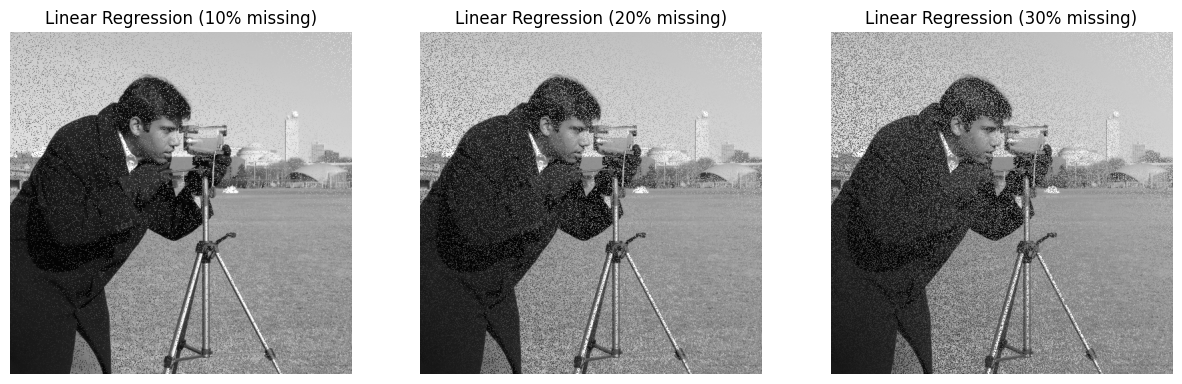

SSIM (Linear Regression):
10% missing: 0.5642
20% missing: 0.4602
30% missing: 0.4029


In [55]:
# --- Function to impute missing pixels using Linear Regression ---
def impute_linear_regression(masked_image):
    """
    masked_image: 2D numpy array with NaN for missing pixels
    Use (x, y) coordinates as features and pixel value as target
    """
    filled_image = masked_image.copy()
    rows, cols = np.indices(filled_image.shape)
    
    # Flatten arrays
    X = np.column_stack((rows.ravel(), cols.ravel()))
    y = filled_image.ravel()
    
    # Mask for known pixels
    known_mask = ~np.isnan(y)
    
    # Train Linear Regression on known pixels
    model = LinearRegression()
    model.fit(X[known_mask], y[known_mask])
    
    # Predict missing pixels
    missing_mask = np.isnan(y)
    y[missing_mask] = model.predict(X[missing_mask])
    
    # Reshape back to image
    filled_image = y.reshape(filled_image.shape)
    filled_image = np.clip(filled_image, 0, 255)
    return filled_image

# --- Apply Linear Regression imputation ---
reconstructed_lr_10 = impute_linear_regression(image_missing_10)
reconstructed_lr_20 = impute_linear_regression(image_missing_20)
reconstructed_lr_30 = impute_linear_regression(image_missing_30)

# --- Display reconstructed images ---
fig, axes = plt.subplots(1,3, figsize=(15,5))
for ax, img, perc in zip(axes, [reconstructed_lr_10, reconstructed_lr_20, reconstructed_lr_30], [10, 20, 30]):
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Linear Regression ({perc}% missing)')
    ax.axis('off')
plt.show()

# --- Compute SSIM ---
ssim_lr_10 = ssim(image, reconstructed_lr_10, data_range=image.max()-image.min())
ssim_lr_20 = ssim(image, reconstructed_lr_20, data_range=image.max()-image.min())
ssim_lr_30 = ssim(image, reconstructed_lr_30, data_range=image.max()-image.min())

print("SSIM (Linear Regression):")
print(f"10% missing: {ssim_lr_10:.4f}")
print(f"20% missing: {ssim_lr_20:.4f}")
print(f"30% missing: {ssim_lr_30:.4f}")


This cell imputes missing pixels using a Linear Regression model

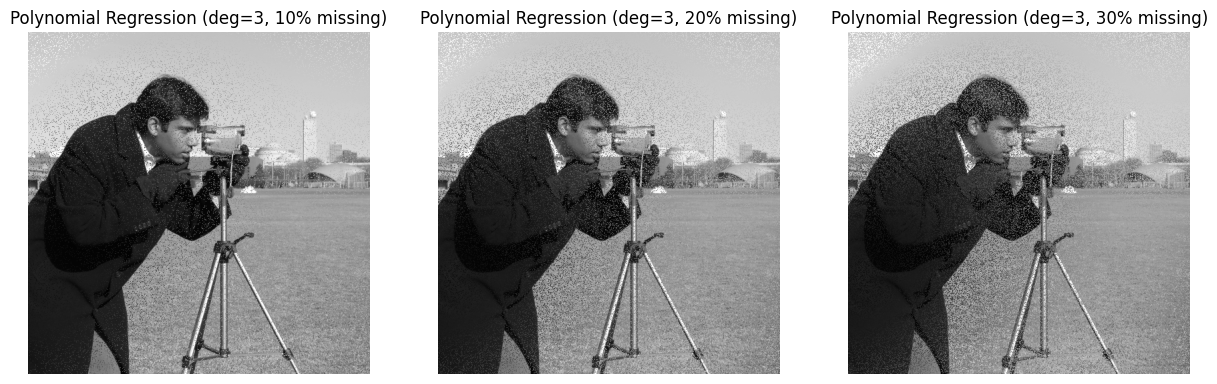

SSIM (Polynomial Regression, degree=3):
10% missing: 0.6709
20% missing: 0.5666
30% missing: 0.5056


In [56]:
# --- Function for Polynomial Regression Imputation ---
def impute_polynomial(masked_image, degree=2):
    """
    masked_image: 2D numpy array with NaN for missing pixels
    degree: polynomial degree (1 to 10)
    """
    filled_image = masked_image.copy()
    rows, cols = np.indices(filled_image.shape)
    
    # Flatten arrays
    X = np.column_stack((rows.ravel(), cols.ravel()))
    y = filled_image.ravel()
    
    # Mask for known pixels
    known_mask = ~np.isnan(y)
    
    # Polynomial Regression pipeline
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X[known_mask], y[known_mask])
    
    # Predict missing pixels
    missing_mask = np.isnan(y)
    y[missing_mask] = model.predict(X[missing_mask])
    
    # Reshape back to image
    filled_image = y.reshape(filled_image.shape)
    filled_image = np.clip(filled_image, 0, 255)
    return filled_image

# --- Apply Polynomial Regression (example with degree=3) ---
degree = 3
reconstructed_poly_10 = impute_polynomial(image_missing_10, degree)
reconstructed_poly_20 = impute_polynomial(image_missing_20, degree)
reconstructed_poly_30 = impute_polynomial(image_missing_30, degree)

# --- Display reconstructed images ---
fig, axes = plt.subplots(1,3, figsize=(15,5))
for ax, img, perc in zip(axes, [reconstructed_poly_10, reconstructed_poly_20, reconstructed_poly_30], [10, 20, 30]):
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Polynomial Regression (deg={degree}, {perc}% missing)')
    ax.axis('off')
plt.show()

# --- Compute SSIM ---
ssim_poly_10 = ssim(image, reconstructed_poly_10, data_range=image.max()-image.min())
ssim_poly_20 = ssim(image, reconstructed_poly_20, data_range=image.max()-image.min())
ssim_poly_30 = ssim(image, reconstructed_poly_30, data_range=image.max()-image.min())

print(f"SSIM (Polynomial Regression, degree={degree}):")
print(f"10% missing: {ssim_poly_10:.4f}")
print(f"20% missing: {ssim_poly_20:.4f}")
print(f"30% missing: {ssim_poly_30:.4f}")

This cell imputes missing pixels using Polynomial Regression

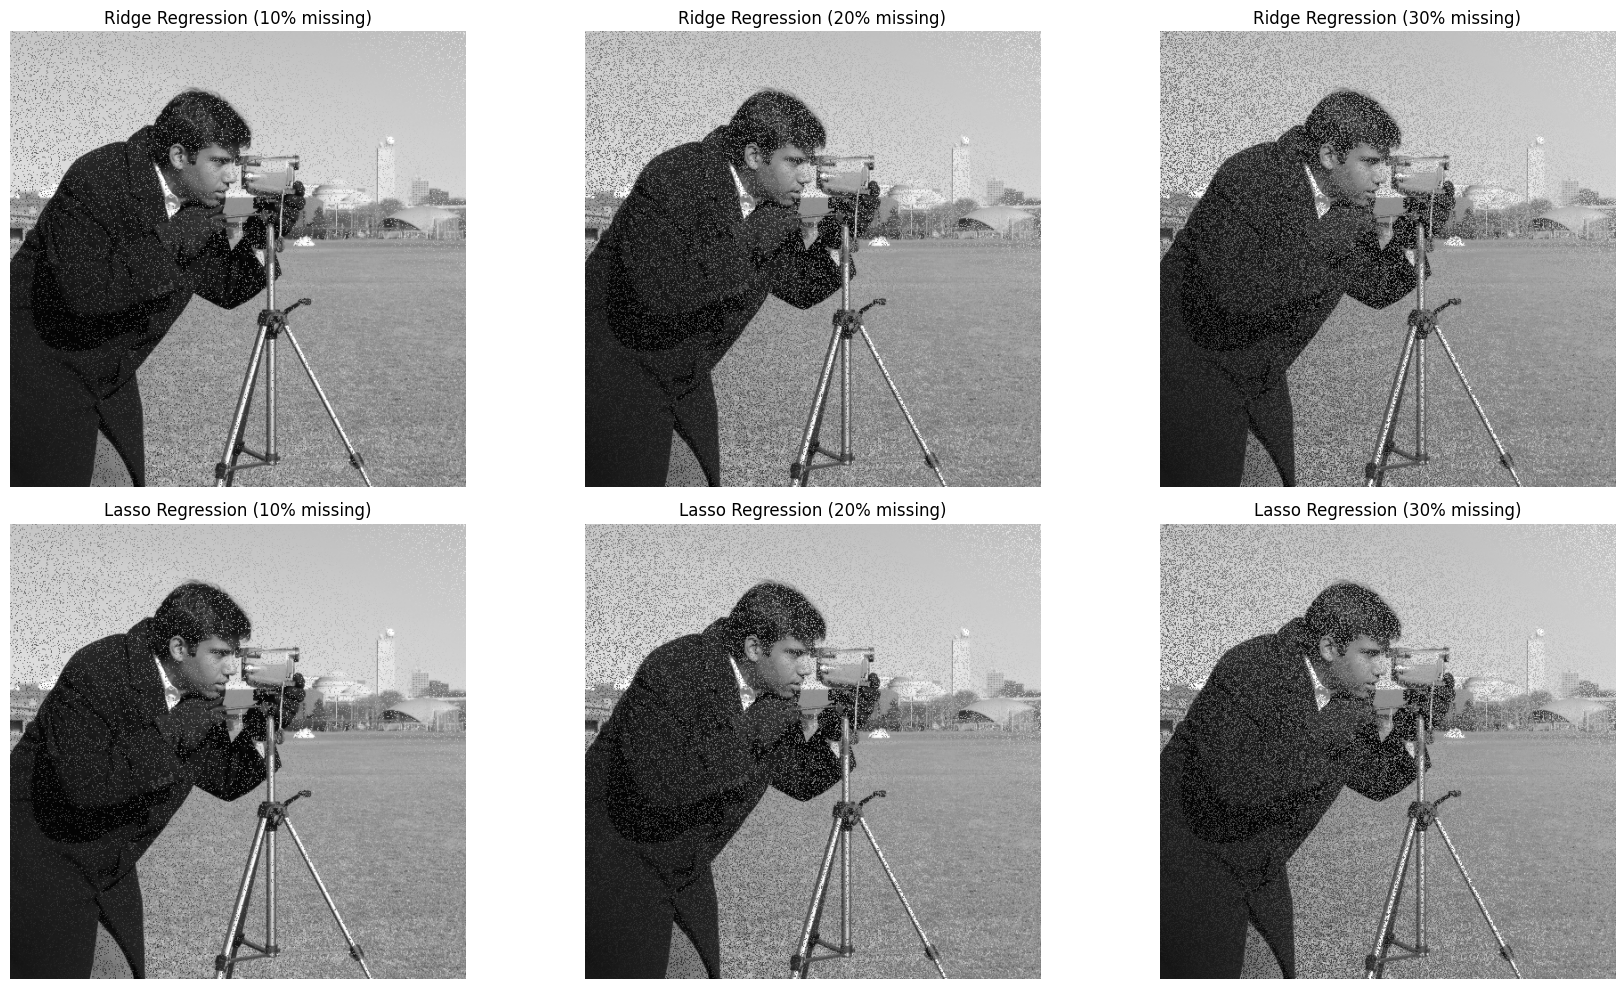

SSIM (Ridge Regression):
10% missing: 0.5642
20% missing: 0.4602
30% missing: 0.4029
SSIM (Lasso Regression):
10% missing: 0.5642
20% missing: 0.4602
30% missing: 0.4029


In [57]:
# --- Function for Ridge Regression Imputation ---
def impute_ridge(masked_image, alpha=1.0):
    filled_image = masked_image.copy()
    rows, cols = np.indices(filled_image.shape)
    X = np.column_stack((rows.ravel(), cols.ravel()))
    y = filled_image.ravel()
    known_mask = ~np.isnan(y)
    
    model = Ridge(alpha=alpha)
    model.fit(X[known_mask], y[known_mask])
    
    missing_mask = np.isnan(y)
    y[missing_mask] = model.predict(X[missing_mask])
    
    filled_image = y.reshape(filled_image.shape)
    filled_image = np.clip(filled_image, 0, 255)
    return filled_image

# --- Function for Lasso Regression Imputation ---
def impute_lasso(masked_image, alpha=0.1):
    filled_image = masked_image.copy()
    rows, cols = np.indices(filled_image.shape)
    X = np.column_stack((rows.ravel(), cols.ravel()))
    y = filled_image.ravel()
    known_mask = ~np.isnan(y)
    
    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(X[known_mask], y[known_mask])
    
    missing_mask = np.isnan(y)
    y[missing_mask] = model.predict(X[missing_mask])
    
    filled_image = y.reshape(filled_image.shape)
    filled_image = np.clip(filled_image, 0, 255)
    return filled_image

# --- Apply Ridge Regression ---
reconstructed_ridge_10 = impute_ridge(image_missing_10, alpha=1.0)
reconstructed_ridge_20 = impute_ridge(image_missing_20, alpha=1.0)
reconstructed_ridge_30 = impute_ridge(image_missing_30, alpha=1.0)

# --- Apply Lasso Regression ---
reconstructed_lasso_10 = impute_lasso(image_missing_10, alpha=0.1)
reconstructed_lasso_20 = impute_lasso(image_missing_20, alpha=0.1)
reconstructed_lasso_30 = impute_lasso(image_missing_30, alpha=0.1)

# --- Display Ridge and Lasso results for all missing percentages ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns

# First row: 10%, 20%, 30% Ridge
for i, img in enumerate([reconstructed_ridge_10, reconstructed_ridge_20, reconstructed_ridge_30]):
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(f'Ridge Regression ({[10,20,30][i]}% missing)')
    axes[0, i].axis('off')

# Second row: 10%, 20%, 30% Lasso
for i, img in enumerate([reconstructed_lasso_10, reconstructed_lasso_20, reconstructed_lasso_30]):
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].set_title(f'Lasso Regression ({[10,20,30][i]}% missing)')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()
# --- Compute SSIM ---
ssim_ridge_10 = ssim(image, reconstructed_ridge_10, data_range=image.max()-image.min())
ssim_ridge_20 = ssim(image, reconstructed_ridge_20, data_range=image.max()-image.min())
ssim_ridge_30 = ssim(image, reconstructed_ridge_30, data_range=image.max()-image.min())

ssim_lasso_10 = ssim(image, reconstructed_lasso_10, data_range=image.max()-image.min())
ssim_lasso_20 = ssim(image, reconstructed_lasso_20, data_range=image.max()-image.min())
ssim_lasso_30 = ssim(image, reconstructed_lasso_30, data_range=image.max()-image.min())

print("SSIM (Ridge Regression):")
print(f"10% missing: {ssim_ridge_10:.4f}")
print(f"20% missing: {ssim_ridge_20:.4f}")
print(f"30% missing: {ssim_ridge_30:.4f}")

print("SSIM (Lasso Regression):")
print(f"10% missing: {ssim_lasso_10:.4f}")
print(f"20% missing: {ssim_lasso_20:.4f}")
print(f"30% missing: {ssim_lasso_30:.4f}")

This cell imputes missing pixels using Ridge and Lasso Regression. Ridge adds L2 regularization and Lasso adds L1 regularization to the linear model.

SSIM Comparison Table:


Method  10% missing  20% missing  30% missing
0                Mean     0.438171     0.353261     0.303723
1            Gaussian     0.304338     0.185326     0.132250
2             Uniform     0.288336     0.171941     0.122311
3   Linear Regression     0.564214     0.460225     0.402947
4  Polynomial (deg=3)     0.670871     0.566568     0.505649
5               Ridge     0.564214     0.460225     0.402947
6               Lasso     0.564212     0.460223     0.402945

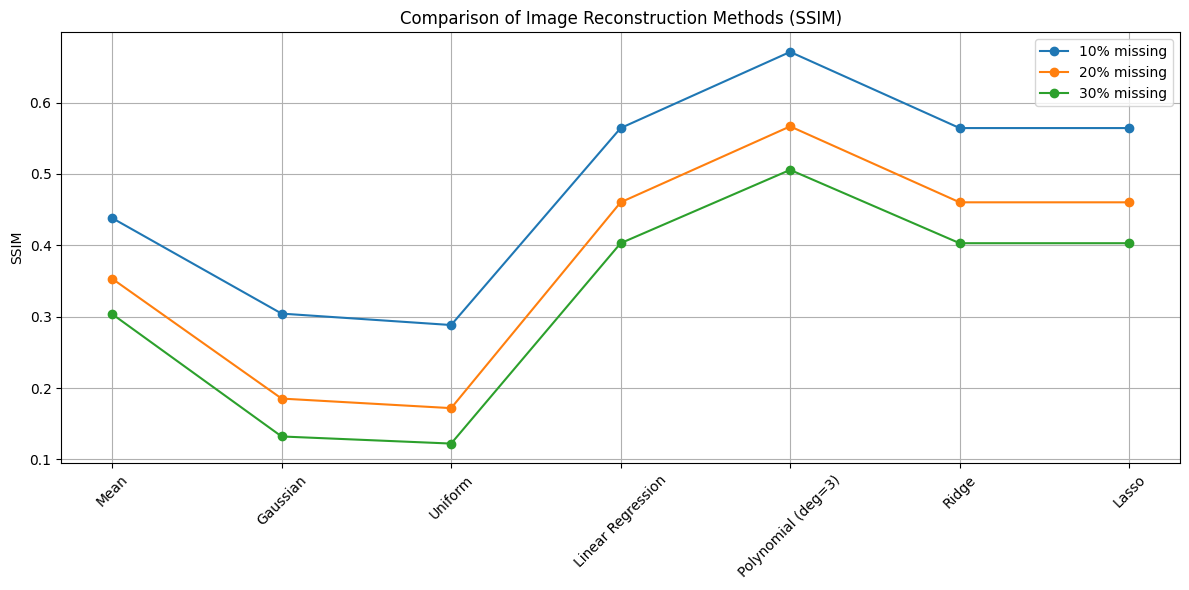

In [58]:

# --- Prepare SSIM data ---
methods = ['Mean', 'Gaussian', 'Uniform', 'Linear Regression', 'Polynomial (deg=3)', 'Ridge', 'Lasso']
ssim_10 = [ssim_10, ssim_gauss_10, ssim_uniform_10, ssim_lr_10, ssim_poly_10, ssim_ridge_10, ssim_lasso_10]
ssim_20 = [ssim_20, ssim_gauss_20, ssim_uniform_20, ssim_lr_20, ssim_poly_20, ssim_ridge_20, ssim_lasso_20]
ssim_30 = [ssim_30, ssim_gauss_30, ssim_uniform_30, ssim_lr_30, ssim_poly_30, ssim_ridge_30, ssim_lasso_30]

# --- Create DataFrame ---
ssim_df = pd.DataFrame({
    'Method': methods,
    '10% missing': ssim_10,
    '20% missing': ssim_20,
    '30% missing': ssim_30
})

print("SSIM Comparison Table:")
display(ssim_df)

# --- Plot comparison ---
plt.figure(figsize=(12,6))
for perc, ssim_vals in zip([10,20,30], [ssim_10, ssim_20, ssim_30]):
    plt.plot(methods, ssim_vals, marker='o', label=f'{perc}% missing')

plt.xticks(rotation=45)
plt.ylabel('SSIM')
plt.title('Comparison of Image Reconstruction Methods (SSIM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


معیار SSIM (Structural Similarity Index Measure) برای مقایسه‌ی شباهت بین دو تصویر استفاده می‌شود. این معیار برخلاف معیارهایی مثل MSE یا PSNR، به‌جای مقایسه‌ی پیکسل‌به‌پیکسل، ساختار کلی، روشنایی و کنتراست تصاویر را بررسی می‌کند. مقدار SSIM بین ۰ تا ۱ است که عدد ۱ یعنی دو تصویر کاملاً مشابه‌اند، پس هرچه مقدار SSIM بیشتر باشد، کیفیت تصویر بهتر و شباهت بیشتری دارد.